In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [4]:
plt.style.use(['ggplot'])

In [5]:
epsilon = np.random.normal(0, 1, 10000).reshape(-1,1)
X = np.random.normal(5, 1, 10000).reshape(-1,1)
y = 2 + 5*X + epsilon

Text(0, 0.5, '$y$')

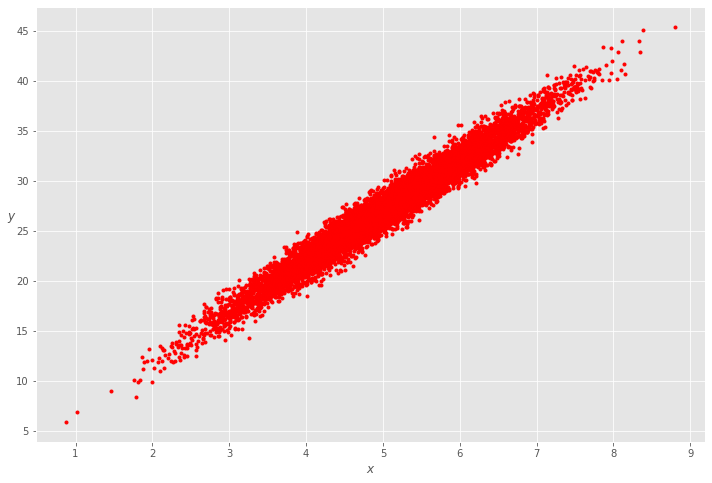

In [6]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(X,y,'r.')
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", rotation=0, fontsize=12)

## Сравнение градиентного спуска с его стохастическим вариантом

Здесь мы попробуем сравнить обычный и стохастический градиентный спуск. Задача оптимизации у нас довольно простая --- линейная регрессия на сгенерированных нормальных данных.
Введем критерий остановки tolerance: когда соседние итерации мало отличаются друг от друга, мы делаем остановку. Сразу оговоримся, что в случае стохастического градиентного спуска за "итерацию" мы будем считать $N$ подряд обновлений параметров. Подобный подход реализован в библиотеке sklearn в классах SGDRegressor, SGDClassifier, и т.п. В случае же обычного спуска, итерацией является один шаг обновления параметров, так как там обновление происходит по всей выборке сразу.

In [27]:
def loss_func(beta,X,y):
    n = len(y)
    predictions = X.dot(beta)
    loss = (1/2*n) * np.sum(np.square(predictions-y))
    return loss
def gradient_descent(X,y,beta,rate=0.01,iterations=100, tol=0.00005):
    n = len(y)
    loss_history = np.zeros(iterations)
    beta_history = np.zeros((iterations,2))
    tol_count = 0
    for it in range(iterations):
        beta_prev = beta
        prediction = np.dot(X,beta)
        beta = beta -(1/n)*rate*( X.T.dot((prediction - y)))
        beta_history[it,:] =beta.T
        loss_history[it]  = loss_func(beta,X,y)
        if (np.sqrt(np.sum((beta_prev - beta)**2)) < tol): 
            tol_count += 1
        else:
            tol_count = 0
        if tol_count >= 3:
            break
    return beta, loss_history, beta_history, it

In [28]:
rate = 0.01
iterations = 10000000
beta = np.random.randn(2,1)

X_one = np.c_[np.ones((len(X),1)),X]
start = time.perf_counter()
beta,loss_history,beta_history, it = gradient_descent(X_one,y,beta,rate,iterations)
end = time.perf_counter()

print('Time: ' + str(end - start))
print('Beta_0:          {:0.3f},\nBeta_1:          {:0.3f}'.format(beta[0][0],beta[1][0]))
#print('Final cost/MSE:  {:0.3f}'.format(loss_history[-1]))

Time: 0.014972289000070305
Beta_0:          2.040,
Beta_1:          4.992


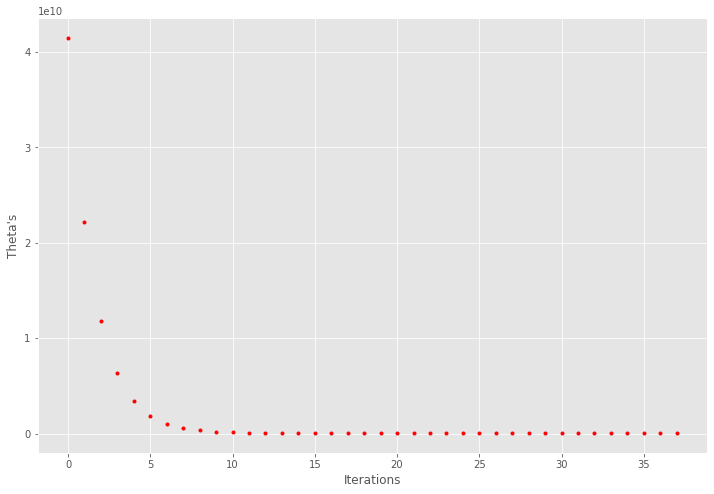

In [29]:
fig,ax = plt.subplots(figsize=(12,8))
ax.set_ylabel("Theta's")
ax.set_xlabel('Iterations')
_=ax.plot(range(it),loss_history[0:it],'r.')

Количество итераций 

In [30]:
print(it)

38


In [17]:
def stocashtic_gradient_descent(X,y,beta,rate=0.01,iterations=10, tol=0.00005):
    n = len(y)
    loss_history = np.zeros(iterations)
    
    it = 0
    tol_count = 0
    while (it < iterations):
        beta_prev = beta
        loss = 0.0
        #for i in range(m):
        rand_ind = np.random.randint(0,n)
        X_i = X[rand_ind,:].reshape(1,X.shape[1])
        y_i = y[rand_ind].reshape(1,1)
        prediction = np.dot(X_i,beta)

        beta = beta -(1/n)*rate*( X_i.T.dot((prediction - y_i)))
        loss += loss_func(beta,X_i,y_i)
        loss_history[it]  = loss
        if (np.sqrt(np.sum((beta_prev - beta)**2)) > tol):
            tol_count = 0
        else:
            tol_count += 1
        it += 1
        if (tol_count >= 3*n): 
            break
    return beta, loss_history, it

In [18]:
rate =0.01
iterations = 10000000
beta = np.random.randn(2,1)

X_one = np.c_[np.ones((len(X),1)),X]
start = time.perf_counter()
beta,loss_history, iterations = stocashtic_gradient_descent(X_one,y,beta,rate,iterations)
end = time.perf_counter()

print('Time: ' + str(end - start))
print('Beta_0:          {:0.3f},\nBeta_1:          {:0.3f}'.format(beta[0][0],beta[1][0]))
#print('Final cost/MSE:  {:0.3f}'.format(loss_history[-1]))

Time: 3.0385655259997293
Beta_0:          1.889,
Beta_1:          4.763


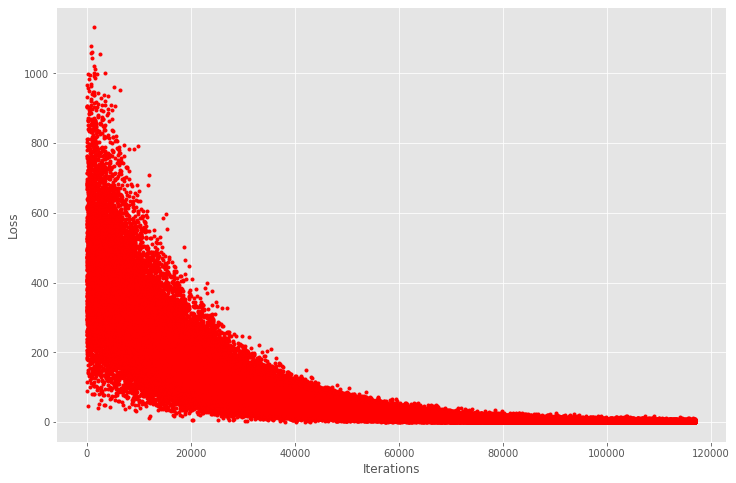

In [19]:
fig,ax = plt.subplots(figsize=(12,8))

ax.set_ylabel("Loss")
ax.set_xlabel('Iterations')
_=ax.plot(range(iterations),loss_history[0:iterations],'r.')

Количество "итераций"

In [20]:
iterations // len(y)

11

Видно, что стохастический градиентный спуск ведет себя хуже в данной задаче: чтобы достичь приемлемого качества, требуется достаточно много операций (при этом не стоит смотреть на время: это все таки "ручная" неоптимальная реализация).
В рамках такой задачи прекрасно справляется обычный градиентный спуск. Стохастический вариант годится больше для случаев, таких как: разреженные данные, анализ естественного языка.

## Эксперименты с готовыми решениями

In [5]:
from sklearn.linear_model import SGDClassifier, SGDRegressor, Lasso, Ridge
from sklearn.datasets.samples_generator import make_regression
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

## Линейные модели, использующие SGD

Рассмотрим здесь методы обучения, использующие стохастический градиентный спуск в качестве метода оптимизации. В библиотеке sklearn это классы SGDRegressor и SGDClassifier.

### Регрессия


Сгенерируем обучающую выборку для регрессии. Параметр noise отвечает за дисперсию шума, effective rank  задает настоящий ранг матрицы плана. По умолчанию количество признаков здесь равно 100.

In [6]:
X, y = make_regression(n_samples=100000, noise=1, effective_rank=8)

#### SGDRegressor

Этот класс позволяет применять SGD ко всем стандартным видам регрессии. Рассмотрим подробнее параметры класса SGDRegressor. 

- loss: функция потерь, 'squared loss' означает минимизацию MSE. 
- penalty: 'l1', 'l2', или 'elasticnet' --- параметр добавляемой регуляризации. 
- learning_rate: скорость обучения, коэффициент $ \eta_t $ перед градиентом при выполнении шага:
    - 'constant': скорость обучения постоянная на каждом шаге и равна $\eta_0$.
    - 'invscaling': скорость обучения выражается формулой $\eta_t = t^{power_t})$.
    - 'optimal': $\eta_t = 1/(\alpha*(t + t_0))$, где $t_0$ выбирается эвристически по Leon Bottou.
    - 'adaptive': $\eta = \eta_0$ до тех пор, пока loss уменьшается. Как только n_iter_no_change итераций не происходит улучшения, $\eta$ делится на 5 и обучение продолжается.
- alpha: параметр регуляризации
- n_iter_no_change: количество итераций без изменений целевой функции, идущих подряд, после которых процесс останавливается
- max_iter: количество итераций, после которых процесс останавливается в любом случае.
- eta0: начальное значение $\eta$

Возьмем линейную регрессию с  L1-регуляризацией (LASSO) и посмотрим на поведение при различных параметрах.

In [7]:
model_sgd = SGDRegressor(loss='squared_loss', penalty='l1', learning_rate='adaptive', alpha=0.0001, 
                         n_iter_no_change= 5, max_iter=500)

Будем варьировать параметры eta0 и learning_rate. Для каждой комбинации параметров оценим качество с помощью кросс-валидации, и построим графики. Отметим, что для стохастического градиентного спуска важна стандартизация. Постоянное значение шага рассматривать не будем, так как в таком случае метод часто вообще не сходится.

In [11]:
lr_s = ['optimal', 'invscaling', 'adaptive']
eta0_s = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
n_iter_s = []
mse_s = []
mean_mse_s = []
errors = []
iter_errors = []

types_mse = dict()
types_err = dict()
types_iter = dict()

for lr in lr_s: 
    print(lr)
    mean_mse_s = list()
    errors = list()
    mean_iters = list()
    for eta0 in eta0_s:
        print(eta0)
        model_sgd.set_params(eta0=eta0, learning_rate=lr)
        kf = KFold(n_splits=5)
        folds_mse = list()
        folds_iters = list()
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            sc = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_test = sc.transform(X_test)        
            model_sgd.fit(X_train, y_train)
            preds = model_sgd.predict(X_test)
            folds_mse.append(mean_squared_error(y_test, preds))
            folds_iters.append(model_sgd.n_iter_)
        mean_mse_s.append(np.mean(folds_mse))
        errors.append(np.std(folds_mse))
        mean_iters.append(np.mean(folds_iters))
        #iter_errors.append(np.mean(folds_iters))
        
    types_mse[lr] = mean_mse_s
    types_err[lr] = errors
    types_iter[lr] = mean_iters

optimal
0.0001
0.0005
0.001
0.005
0.01
0.05
0.1
0.2
0.3
0.5
1
invscaling
0.0001
0.0005
0.001
0.005
0.01
0.05
0.1
0.2
0.3
0.5
1
adaptive
0.0001
0.0005
0.001
0.005
0.01
0.05
0.1
0.2
0.3
0.5
1


Среднеквадратичное отклонение, оцененное по кросс-валидации для разных learning_rate, выглядит так. Видно, что адаптивный выбор шага дает лучшее значение, причем с меньшей ошибкой.

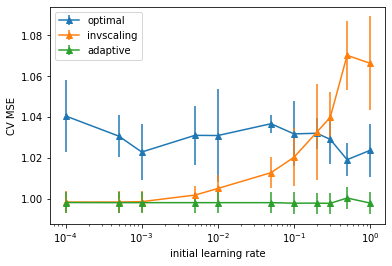

In [12]:
for lr in types_mse.keys():
    plt.errorbar(eta0_s, types_mse[lr], types_err[lr], marker='^', label=lr)

plt.legend()
plt.xscale('log')
plt.xlabel('initial learning rate')
plt.ylabel('CV MSE')
plt.show()

Также рассмотрим количество итераций, понадобившееся для сходимости метода при том или ином шаге градиента

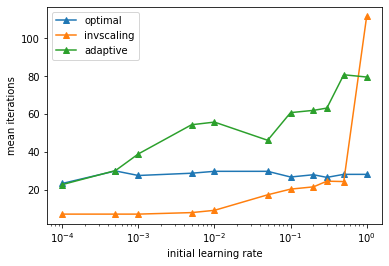

In [13]:
for lr in types_iter.keys():
    plt.plot(eta0_s, types_iter[lr], label=lr, marker='^')
    
plt.legend()
plt.xscale('log')
plt.xlabel('initial learning rate')
plt.ylabel('mean iterations')
plt.show()

Заметим следующее: если выбирать и learning_rate, и eta0, то подходит invscaling с маленьким eta0; если выбирать только learning_rate, то в смысле качества adaptive ведет себя стабильнее и лучше.

Запустим также обычный LASSO, так же по кросс-валидации оценим MSE.

In [55]:
lasso = Lasso(alpha=0.0001)
cvs = cross_val_score(lasso, X, y, cv=5, scoring='neg_mean_squared_error')
print("CV-mean MSE Score: ", -np.mean(cvs))
print("standard deviation: ", np.std(cvs))

CV-mean MSE Score:  1.023998317737703
standard deviation:  0.008289940484972844


Обратим внимание на то, что в cross_val_score() передается 'neg_mean_squared_error' --- это минус MSE. Дело в том, что в данном случае считается, что большему значению метрики соответствует большее качество.